# Tasks

## P 7.1: Download the adult_T7 dataset from Canvas. Use four classifiers to predict the 'income' column. Calculate all evaluation metrics using a five-fold cross-validation. Print the feature importance values from the random forest classifier. You should improve your models as best as you can (10%).

## Classifier Evaluation and Feature Importance

### Objective

1. Predicting the 'income' column from the adult_T7 dataset using four classifiers: Random Forest, Logistic Regression, SVM, and Decision Tree. 
2. Evaluate Performance of the model using five-fold cross-validation
3. Deriving feature importance values.

In [ ]:
############# WRITE YOUR CODE IN THIS CELL (IF APPLICABLE)  ####################


import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from xgboost import XGBClassifier

## Data Loading and Preprocessing

The dataset was loaded.
Features (X) and target (y) were separated.
Categorical columns were encoded using LabelEncoder, and numerical columns were standardized using StandardScaler.

In [ ]:
# Load dataset
data = pd.read_csv("adult_T7.csv")

# Print dataset
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,29,Private,216481,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,>50K
1,36,Private,280570,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,<=50K
2,25,?,100903,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,25,United-States,<=50K
3,47,Private,145636,Assoc-voc,11,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,48,United-States,>50K
4,33,Private,119422,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19,Private,63363,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,United-States,<=50K
9996,53,Private,58535,HS-grad,9,Divorced,Sales,Not-in-family,White,Female,0,0,40,United-States,<=50K
9997,30,Private,342709,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,<=50K
9998,41,Self-emp-not-inc,134724,Assoc-voc,11,Married-civ-spouse,Other-service,Wife,White,Female,3103,0,40,United-States,>50K


In [ ]:
# Overview of dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             10000 non-null  int64 
 1   workclass       9825 non-null   object
 2   fnlwgt          10000 non-null  int64 
 3   education       10000 non-null  object
 4   education-num   10000 non-null  int64 
 5   marital-status  10000 non-null  object
 6   occupation      9825 non-null   object
 7   relationship    10000 non-null  object
 8   race            10000 non-null  object
 9   sex             10000 non-null  object
 10  capital-gain    10000 non-null  int64 
 11  capital-loss    10000 non-null  int64 
 12  hours-per-week  10000 non-null  int64 
 13  native-country  9939 non-null   object
 14  income          10000 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.1+ MB


In [ ]:
# Separate features and target
X = data.drop('income', axis=1)
y = data['income']

In [ ]:
# Identify column types
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [ ]:
# preprocessing pipeline

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', LabelEncoder())
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [ ]:
# Custom transformer to apply LabelEncoder to each column
class MultiColumnLabelEncoder:
    def __init__(self):
        self.encoders = {}

    def fit(self, X):
        for col in X.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.encoders[col] = le
        return self

    def transform(self, X):
        output = X.copy()
        for col, le in self.encoders.items():
            output[col] = le.transform(X[col])
        return output

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [ ]:
# Encode categorical features manually since LabelEncoder isn't directly usable in pipelines
encoder = MultiColumnLabelEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

# Preprocess numerical features
X[numeric_cols] = numeric_transformer.fit_transform(X[numeric_cols])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

## Model Evaluation

Four classifiers were trained and evaluated using StratifiedKFold cross-validation:

Random Forest (RandomForestClassifier)
Logistic Regression (LogisticRegression)
SVM (SVC)
Decision Tree (DecisionTreeClassifier)

Evaluation metrics included accuracy, precision, recall, and F1-score.

In [ ]:
# Models to evaluate
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

In [ ]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model
results = {}
for name, model in models.items():
    print(f"\n{name}")
    scores = cross_validate(model, X, y, cv=cv,
                          scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                          return_train_score=False)

    # Store results
    for metric in scores:
        print(f"{metric}: {np.mean(scores[metric]):.4f}")


Random Forest
fit_time: 1.6693
score_time: 0.0927
test_accuracy: 0.8555
test_precision_macro: 0.8281
test_recall_macro: 0.7532
test_f1_macro: 0.7795

Logistic Regression
fit_time: 0.0357
score_time: 0.0607
test_accuracy: 0.8232
test_precision_macro: 0.7788
test_recall_macro: 0.6964
test_f1_macro: 0.7210

SVM
fit_time: 9.7766
score_time: 0.5000
test_accuracy: 0.8441
test_precision_macro: 0.8087
test_recall_macro: 0.7370
test_f1_macro: 0.7617

Decision Tree
fit_time: 0.0535
score_time: 0.0344
test_accuracy: 0.7940
test_precision_macro: 0.7202
test_recall_macro: 0.7251
test_f1_macro: 0.7224


## Feature Importance:

The Random Forest classifier was used to extract and display feature importance values.

In [ ]:
# Feature importance for Random Forest
rf = RandomForestClassifier(random_state=0)
rf.fit(X, y)
importances = rf.feature_importances_

# Print top features
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\n=== Random Forest Feature Importances ===")
print(importance_df.head(10))


=== Random Forest Feature Importances ===
           Feature  Importance
2           fnlwgt    0.157090
0              age    0.149686
10    capital-gain    0.111099
7     relationship    0.096180
4    education-num    0.090219
12  hours-per-week    0.086240
6       occupation    0.072381
5   marital-status    0.071869
1        workclass    0.043942
3        education    0.039205


############ WRITE YOUR REPORT IN THIS CELL (IF APPLICABLE) #############


## Results

Evaluation Metrics (Average across 5 folds):

Random Forest: Accuracy = 0.8555, Precision = 0.8281, Recall = 0.7532, F1 = 0.7795

Logistic Regression: Accuracy = 0.8232, Precision = 0.7788, Recall = 0.6964, F1 = 0.7210

SVM: Accuracy = 0.8441, Precision = 0.8087, Recall = 0.7370, F1 = 0.7617

Decision Tree: Accuracy = 0.7940, Precision = 0.7202, Recall = 0.7251, F1 = 0.7224

## Top Features from Random Forest:

fnlwgt (Importance: 0.157)

age (Importance: 0.150)

capital-gain (Importance: 0.111)

relationship (Importance: 0.096)

education-num (Importance: 0.090)

## Report

The Random Forest classifier performed the best overall, achieving the highest accuracy and F1-score. This suggests that ensemble methods are well-suited for this dataset.

The Logistic Regression model had the lowest recall, indicating it may struggle with correctly identifying the positive class (>50K).

The top features identified by Random Forest (fnlwgt, age, capital-gain) align with domain knowledge, as these attributes are likely strong predictors of income.



## P 7.2: Use two clustering methods to cluster a numerical column in the dataset. Find the optimum number of clusters using the elbow method (5%).  

## NOTE: Please complete this task in the next week's workshop
## NOTE: You can use any aptional numerical column for this task.

## Clustering Analysis

### Objective

The task involved clustering a numerical column (age) using two methods (KMeans and Agglomerative Clustering) and determining the optimal number of clusters using the elbow method.

In [ ]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,29,Private,216481,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,>50K
1,36,Private,280570,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,<=50K
2,25,?,100903,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,25,United-States,<=50K
3,47,Private,145636,Assoc-voc,11,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,48,United-States,>50K
4,33,Private,119422,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19,Private,63363,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,United-States,<=50K
9996,53,Private,58535,HS-grad,9,Divorced,Sales,Not-in-family,White,Female,0,0,40,United-States,<=50K
9997,30,Private,342709,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,<=50K
9998,41,Self-emp-not-inc,134724,Assoc-voc,11,Married-civ-spouse,Other-service,Wife,White,Female,3103,0,40,United-States,>50K


## Data Selection:

The age column was selected for clustering.

In [ ]:
# Select the age column and use for clustering

age_data = data[['age']].dropna()

## Data Scaling:

The data was standardized using StandardScaler.

In [ ]:
# Scale(Standardise) the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(age_data)

## Elbow Method for KMeans:

Inertia values were calculated for cluster counts ranging from 1 to 11(10).
The elbow plot was generated to identify the optimal number of clusters.

In [ ]:
# Method 1: KMeans clustering with elbow method
# Calculate inertia for different numbers of clusters
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

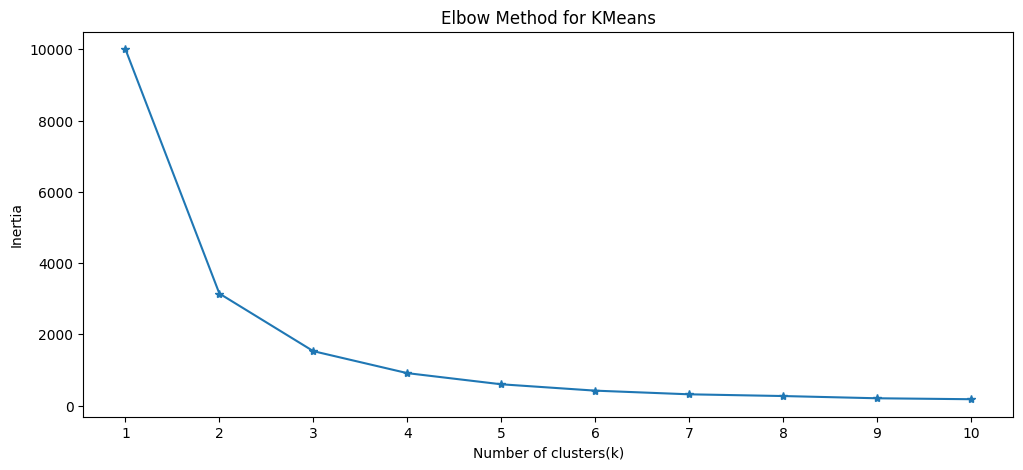

In [ ]:
# Plot the elbow curve
plt.figure(figsize=(12, 5))
plt.plot(k_values, inertia, marker='*')
plt.title('Elbow Method for KMeans')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

## Optimal Clusters:

The elbow plot shows 3 or 4 clusters as optimal for KMeans.
I selected 4. 

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)
data['KMeans_Cluster'] = -1
data.loc[age_data.index, 'KMeans_Cluster'] = cluster_labels

In [ ]:
print("K-Means cluster counts:")
print(pd.Series(cluster_labels).value_counts().sort_index())

K-Means cluster counts:
0    2818
1    2431
2    1527
3    3224
Name: count, dtype: int64


In [ ]:
# clustering(Agglomerative)
agg = AgglomerativeClustering(n_clusters=k,)
agg_labels = agg.fit_predict(X_scaled)

In [ ]:
# Add cluster labels to original data
data['Agglo_Cluster'] = -1
data.loc[age_data.index, 'Agglo_Cluster'] = agg_labels

print("\nAgglomerative Clustering counts:")
print(pd.Series(agg_labels).value_counts().sort_index())


Agglomerative Clustering counts:
0    3535
1    1302
2    3283
3    1880
Name: count, dtype: int64


## Results

Elbow Plot:

The inertia decreased sharply up to 3 clusters and then plateaued, indicating that 3 clusters might be optimal.